# The Task

## Project Overview

In the file dataset/data.csv, you will find a dataset containing news articles with the following columns:

label: 0 if the news is fake, 1 if the news is real.
title: The headline of the news article.
text: The full content of the article.
subject: The category or topic of the news.
date: The publication date of the article.
Your goal is to build a classifier that is able to distinguish between the two.

Once you have a classifier built, then use it to predict the labels for dataset/validation_data.csv. Generate a new file where the label 2 has been replaced by 0 (fake) or 1 (real) according to your model. Please respect the original file format, do not include extra columns, and respect the column separator.

Please ensure to split the data.csv into training and test datasets before using it for model training or evaluation.

Guidance
Like in a real life scenario, you are able to make your own choices and text treatment. Use the techniques you have learned and the common packages to process this data and classify the text.

Deliverables
Python Code: Provide well-documented Python code that conducts the analysis.
Predictions: A csv file in the same format as validation_data.csv but with the predicted labels (0 or 1)
Accuracy estimation: Provide the teacher with your estimation of how your model will perform.
Presentation: You will present your model in a 10-minute presentation. Your teacher will provide further instructions.

# Import

In [4]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sb
from nltk import pos_tag
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, auc, roc_curve

# Loading the Data

In [5]:
data = pd.read_csv('../dataset/training_data_lowercase.csv', sep='\t', names=['labels', 'text'])

In [6]:
data

,labels,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...
...,...,...
34147,1,tears in rain as thais gather for late king's ...
34148,1,pyongyang university needs non-u.s. teachers a...
34149,1,philippine president duterte to visit japan ah...
34150,1,japan's abe may have won election\tbut many do...


# Undertanding the Data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  34152 non-null  int64 
 1   text    34152 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.8+ KB


In [8]:
print('Its unique values are ',data['labels'].unique())
print(print(data['labels'].describe()))

Its unique values are  [0 1]
count    34152.000000
mean         0.485477
std          0.499796
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: labels, dtype: float64
None


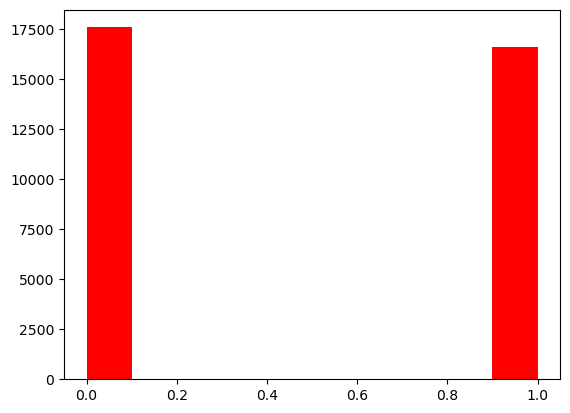

In [9]:
plt.hist(data.labels, color='red')
plt.show()

In [10]:
data.head()

,labels,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [11]:
data.tail()

,labels,text
34147,1,tears in rain as thais gather for late king's ...
34148,1,pyongyang university needs non-u.s. teachers a...
34149,1,philippine president duterte to visit japan ah...
34150,1,japan's abe may have won election\tbut many do...
34151,1,demoralized and divided: inside catalonia's po...


# Preprocessing the Data

## Basic cleaning 

In [12]:
def clean_html_text(text: str) -> str:
    if text is None:
        return ''
    text = str(text)
    # Remove inline JavaScript/CSS
    text = re.sub(r"(?is)<script.*?>.*?</script>", " ", text)
    text = re.sub(r"(?is)<style.*?>.*?</style>", " ", text)
    # Remove HTML comments
    text = re.sub(r"(?s)<!--.*?-->", " ", text)
    # Remove the remaining tag
    text = re.sub(r"(?s)<[^>]+>", " ", text)
    # Remove prefixed b
    text = re.sub(r"^\s*b[\"'](.+?)[\"']\s*$", r"\1", text)
    # Remove video
    # text = re.sub(r"\s*\[video\]$", r"\1", text)    
    # Remove end of the line characters
    text = re.sub(r"\s*[\[\(][^\]\)]+[\]\)]\s*$", "", text)    
    # Remove \t from middle and end of the texts
    text = re.sub(r"\b\\t"," ",text)
    # Remove \t from startof the texts
    text = re.sub(r"^\\t"," ",text)
    # Remove all the special characters and numbers
    text = re.sub(r"[^A-Za-z\s]", " ", text)
    # Remove all single characters
    text = re.sub(r"\b[A-Za-z]\b", " ", text)
    # Remove single characters from the start
    text = re.sub(r"^[A-Za-z]\s+", " ", text)
    # Substitute multiple spaces with single space
    text = re.sub(r"\s+", " ", text).strip()
    # Convert to lowercase
    text = text.lower()
    return text

punct_pattern = f"[{re.escape(string.punctuation)}]"

In [13]:
data['pre_text'] = data['text'].astype(str).apply(lambda x: clean_html_text(x))
data['pre_text'] = data['pre_text'].astype(str).apply(lambda x: re.sub(punct_pattern, "", x))
data['pre_text'] = data['pre_text'].astype(str).apply(lambda x: word_tokenize(x))
data.head()

,labels,text,pre_text
0,0,donald trump sends out embarrassing new year‚s...,"[donald, trump, sends, out, embarrassing, new,..."
1,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus..."
2,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet..."
3,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, obama..."
4,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru..."


## Removing stop words

In [14]:
stop_words = set(stopwords.words('english'))

In [15]:
data['pre_text'] = data['pre_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [16]:
bag_of_words = {}

for lista in data['pre_text']:
    for word in lista:
        if bag_of_words == 0:
            bag_of_words[word] = 1
        elif word in bag_of_words:
            bag_of_words[word] +=1
        else:
            bag_of_words[word] = 1

print(sorted(bag_of_words.items(), key=lambda x: -x[1])[:100])

[('trump', 12805), ('says', 2633), ('obama', 2460), ('house', 1825), ('hillary', 1604), ('clinton', 1474), ('white', 1370), ('new', 1280), ('president', 1213), ('bill', 1098), ('russia', 1059), ('republican', 1023), ('senate', 884), ('state', 808), ('court', 791), ('donald', 761), ('election', 735), ('republicans', 732), ('tax', 719), ('news', 707), ('gop', 707), ('video', 679), ('breaking', 662), ('calls', 643), ('north', 638), ('campaign', 635), ('china', 602), ('korea', 587), ('vote', 583), ('black', 579), ('media', 579), ('watch', 560), ('one', 554), ('gets', 527), ('democrats', 527), ('anti', 524), ('deal', 513), ('may', 507), ('senator', 499), ('fbi', 480), ('america', 480), ('russian', 479), ('iran', 464), ('plan', 460), ('twitter', 450), ('former', 449), ('congress', 447), ('muslim', 442), ('police', 439), ('top', 438), ('back', 437), ('fox', 434), ('government', 434), ('first', 431), ('law', 431), ('people', 425), ('chief', 421), ('cnn', 420), ('governor', 405), ('ban', 405), 

In [17]:
words_to_filter = ['video','says', 'tweets', 'tells','screenshots',
                   'details', 'fck', 'btch', 'images', 'cck', 'image'
                   ,'videos','ahole']

In [18]:
data['pre_text_filter'] = data['pre_text'].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])

In [19]:
bag_of_words = {}

for lista in data['pre_text_filter']:
    for word in lista:
        if bag_of_words == 0:
            bag_of_words[word] = 1
        elif word in bag_of_words:
            bag_of_words[word] +=1
        else:
            bag_of_words[word] = 1

print(sorted(bag_of_words.items(), key=lambda x: -x[1])[:100])

[('trump', 12805), ('obama', 2460), ('house', 1825), ('hillary', 1604), ('clinton', 1474), ('white', 1370), ('new', 1280), ('president', 1213), ('bill', 1098), ('russia', 1059), ('republican', 1023), ('senate', 884), ('state', 808), ('court', 791), ('donald', 761), ('election', 735), ('republicans', 732), ('tax', 719), ('news', 707), ('gop', 707), ('breaking', 662), ('calls', 643), ('north', 638), ('campaign', 635), ('china', 602), ('korea', 587), ('vote', 583), ('black', 579), ('media', 579), ('watch', 560), ('one', 554), ('gets', 527), ('democrats', 527), ('anti', 524), ('deal', 513), ('may', 507), ('senator', 499), ('fbi', 480), ('america', 480), ('russian', 479), ('iran', 464), ('plan', 460), ('twitter', 450), ('former', 449), ('congress', 447), ('muslim', 442), ('police', 439), ('top', 438), ('back', 437), ('fox', 434), ('government', 434), ('first', 431), ('law', 431), ('people', 425), ('chief', 421), ('cnn', 420), ('governor', 405), ('ban', 405), ('party', 399), ('attack', 396),

### Using Stemmer

#### Snowball

In [20]:
snowball = SnowballStemmer('english')

In [21]:
data['snow_text'] = data['pre_text'].apply(lambda tokens: [snowball.stem(token) for token in tokens])

#### Porter

In [22]:
porter = PorterStemmer()

In [23]:
data['porter_text'] = data['pre_text'].apply(lambda tokens: [porter.stem(token) for token in tokens])

### Using Lemmatizer

In [24]:
lemm = WordNetLemmatizer()

In [25]:
data['lemm_text'] = data['pre_text'].apply(lambda tokens: [lemm.lemmatize(token) for token in tokens])

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   labels           34152 non-null  int64 
 1   text             34152 non-null  object
 2   pre_text         34152 non-null  object
 3   pre_text_filter  34152 non-null  object
 4   snow_text        34152 non-null  object
 5   porter_text      34152 non-null  object
 6   lemm_text        34152 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


# Spliting the data into Training and Test

In [27]:
X = data.iloc[:,2:]

In [28]:
y = data.iloc[:,0]

In [29]:
print(X.shape, y.shape)

(34152, 5) (34152,)


## Using only the preprocessed text

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X['pre_text'], y, test_size=0.2, random_state=42)

## Using the preprocessed text + snow stemmer

In [31]:
X_train_snow, X_test_snow, y_train_snow, y_test_snow = train_test_split(X['snow_text'], y, test_size=0.2, random_state=42)

## Using the preprocessed text + porter stemmer

In [32]:
X_train_porter, X_test_porter, y_train_porter, y_test_porter = train_test_split(X['porter_text'], y, test_size=0.2, random_state=42)

## Using the preprocessed text + noise removal

In [33]:
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X['pre_text_filter'], y, test_size=0.2, random_state=42)

## Using the preprocessed text + lemmatizer

In [34]:
X_train_lemm, X_test_lemm, y_train_lemm, y_test_lemm = train_test_split(X['lemm_text'], y, test_size=0.2, random_state=42)

Defining a plotting function for Evaluation phase

In [35]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    model,
    X,
    y,
    scoring="accuracy",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    title=None
):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        scoring=scoring,
        cv=cv,
        train_sizes=train_sizes,
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, marker="o", label="Training score")
    plt.plot(train_sizes, val_mean, marker="o", label="Validation score")
    plt.xlabel("Training set size")
    plt.ylabel(scoring)
    plt.title(title or model.__class__.__name__)
    plt.legend()
    plt.grid(True)
    plt.show()

# Training some classifiers

### Only preprocessed text - Best(TF-IDF Passive Agressive Classifier - Acc: 91.27 %, Gini: 94.29 %)

#### TF-IDF - Best (Passive Agressive Classifier - Acc: 91.27 %, Gini: 94.29 %)

In [36]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

##### Decision Tree metrics

In [37]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_tfidf, y_train)
y_hat = dt_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8552188552188552
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      3529
           1       0.85      0.86      0.85      3302

    accuracy                           0.86      6831
   macro avg       0.86      0.86      0.86      6831
weighted avg       0.86      0.86      0.86      6831

Confusion matrix:
 [[3014  515]
 [ 474 2828]]
Gini coef.: 0.7105169437140977


##### Logistic Regression metrics

In [38]:
log_classifier = LogisticRegression(random_state=42).fit(X_tfidf, y_train)
y_hat = log_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.922266139657444
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      3529
           1       0.92      0.92      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3262  267]
 [ 264 3038]]
Gini coef.: 0.8443896286183921


##### Naive Bayes metrics

In [39]:
nb_classifier = MultinomialNB().fit(X_tfidf, y_train)
y_hat = nb_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9270970575318401
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      3529
           1       0.93      0.92      0.92      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3305  224]
 [ 274 3028]]
Gini coef.: 0.8535459159110661


##### Random Forest metrics

In [40]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_tfidf, y_train)
y_hat = rf_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9035280339628166
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      3529
           1       0.90      0.90      0.90      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion matrix:
 [[3202  327]
 [ 332 2970]]
Gini coef.: 0.8067940654049455


##### PassiveAggressiveClassifier

In [41]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42, n_jobs=-1).fit(X_tfidf, y_train)
y_hat = pac.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = pac.decision_function(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.912750695359391
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      3529
           1       0.91      0.91      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3236  293]
 [ 303 2999]]
Gini coef.: 0.9429757315821712


#### BoW - Best (Naive Bayes - Acc: 93.01 %, Gini: 85.98 % )

In [42]:
vectorizer = CountVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

##### Decision Tree metrics

In [43]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_bow, y_train)
y_hat = dt_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8585858585858586
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      3529
           1       0.85      0.86      0.85      3302

    accuracy                           0.86      6831
   macro avg       0.86      0.86      0.86      6831
weighted avg       0.86      0.86      0.86      6831

Confusion matrix:
 [[3038  491]
 [ 475 2827]]
Gini coef.: 0.7170148903804576


##### Logistic Regression metrics

In [44]:
log_classifier = LogisticRegression(random_state=42).fit(X_bow, y_train)
y_hat = log_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9290001463914508
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3529
           1       0.93      0.93      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3285  244]
 [ 241 3061]]
Gini coef.: 0.8578725311209587


##### Naive Bayes metrics

In [45]:
nb_classifier = MultinomialNB().fit(X_bow, y_train)
y_hat = nb_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.930171277997365
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      3529
           1       0.93      0.92      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3308  221]
 [ 256 3046]]
Gini coef.: 0.8598472567610174


##### Random Forest metrics

In [46]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_bow, y_train)
y_hat = rf_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9006002049480311
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      3529
           1       0.91      0.88      0.90      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion matrix:
 [[3239  290]
 [ 389 2913]]
Gini coef.: 0.8000163566427791


##### PassiveAggressiveClassifier

In [47]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42, n_jobs=-1).fit(X_bow, y_train)
y_hat = pac.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test, y_hat))

y_proba = pac.decision_function(X_test_bow)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8628312106572976
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88      3529
           1       0.96      0.75      0.84      3302

    accuracy                           0.86      6831
   macro avg       0.88      0.86      0.86      6831
weighted avg       0.88      0.86      0.86      6831

Confusion matrix:
 [[3429  100]
 [ 837 2465]]
Gini coef.: 0.941454031740812


### Preprocessed text + noise removal - Best(TF-IDF Passive Agressive Classifier - Acc: 91.21 %, Gini: 93.88 %)

#### TF-IDF - Best (Passive Agressive Classifier - Acc: 91.21 %, Gini: 93.88 % )¶

In [48]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_tfidf = vectorizer.fit_transform(X_train_filt)
X_test_tfidf = vectorizer.transform(X_test_filt)

##### Decision Tree metrics

In [49]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_tfidf, y_train_filt)
y_hat = dt_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8490704142878056
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      3529
           1       0.84      0.84      0.84      3302

    accuracy                           0.85      6831
   macro avg       0.85      0.85      0.85      6831
weighted avg       0.85      0.85      0.85      6831

Confusion matrix:
 [[3013  516]
 [ 515 2787]]
Gini coef.: 0.6978168601802253


##### Logistic Regression metrics

In [50]:
log_classifier = LogisticRegression(random_state=42).fit(X_tfidf, y_train_filt)
y_hat = log_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9194847020933977
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3529
           1       0.92      0.92      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3252  277]
 [ 273 3029]]
Gini coef.: 0.8388303438550773


##### Naive Bayes metrics

In [51]:
nb_classifier = MultinomialNB().fit(X_tfidf, y_train_filt)
y_hat = nb_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9257795344751867
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      3529
           1       0.93      0.91      0.92      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3306  223]
 [ 284 3018]]
Gini coef.: 0.850800814708415


##### Random Forest metrics

In [52]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_tfidf, y_train_filt)
y_hat = rf_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8994290733421169
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      3529
           1       0.90      0.89      0.90      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion matrix:
 [[3204  325]
 [ 362 2940]]
Gini coef.: 0.7982753954042467


##### PassiveAggressiveClassifier

In [53]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42, n_jobs=-1).fit(X_tfidf, y_train_filt)
y_hat = pac.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = pac.decision_function(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9121651295564339
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      3529
           1       0.91      0.90      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3244  285]
 [ 315 2987]]
Gini coef.: 0.9388060749223488


#### BoW - Best (Passive Agressive Classifier - Acc: 90.95 %, Gini: 93.68 % )¶

In [54]:
vectorizer = CountVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_bow = vectorizer.fit_transform(X_train_filt)
X_test_bow = vectorizer.transform(X_test_filt)

##### Decision Tree metrics

In [55]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_bow, y_train_filt)
y_hat = dt_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8521446347533304
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      3529
           1       0.86      0.83      0.85      3302

    accuracy                           0.85      6831
   macro avg       0.85      0.85      0.85      6831
weighted avg       0.85      0.85      0.85      6831

Confusion matrix:
 [[3067  462]
 [ 548 2754]]
Gini coef.: 0.7031247023236902


##### Logistic Regression metrics

In [56]:
log_classifier = LogisticRegression(random_state=42).fit(X_bow, y_train_filt)
y_hat = log_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9285609720392329
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3529
           1       0.93      0.93      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3282  247]
 [ 241 3061]]
Gini coef.: 0.8570224319427213


##### Naive Bayes metrics

In [57]:
nb_classifier = MultinomialNB().fit(X_bow, y_train_filt)
y_hat = nb_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9272434489825794
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      3529
           1       0.93      0.92      0.92      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3311  218]
 [ 279 3023]]
Gini coef.: 0.8537318804698422


##### Random Forest metrics

In [58]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_bow, y_train_filt)
y_hat = rf_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8986971160884204
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      3529
           1       0.91      0.88      0.89      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion matrix:
 [[3231  298]
 [ 394 2908]]
Gini coef.: 0.7962351917031145


##### PassiveAggressiveClassifier

In [59]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42, n_jobs=-1).fit(X_bow, y_train_filt)
y_hat = pac.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_filt, y_hat))
print("Classification Report:\n", classification_report(y_test_filt, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_filt, y_hat))

y_proba = pac.decision_function(X_test_bow)
fpr, tpr, thresholds = roc_curve(y_test_filt, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9095300834431269
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      3529
           1       0.92      0.89      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3261  268]
 [ 350 2952]]
Gini coef.: 0.9368151299460608


### Preprocessed text + snow stemmer - Best(TF-IDF Passive Agressive Classifier - Acc: 90.54 %, Gini: 93.15 %)

#### TF-IDF - Best (Passive Agressive Classifier - Acc: 90.54 %, Gini: 93.15 % )¶

In [60]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_tfidf = vectorizer.fit_transform(X_train_snow)
X_test_tfidf = vectorizer.transform(X_test_snow)

##### Decision Tree metrics

In [61]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_tfidf, y_train_snow)
y_hat = dt_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8451178451178452
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      3529
           1       0.84      0.84      0.84      3302

    accuracy                           0.85      6831
   macro avg       0.84      0.85      0.84      6831
weighted avg       0.85      0.85      0.85      6831

Confusion matrix:
 [[2990  539]
 [ 519 2783]]
Gini coef.: 0.6900880461089127


##### Logistic Regression metrics

In [62]:
log_classifier = LogisticRegression(random_state=42).fit(X_tfidf, y_train_snow)
y_hat = log_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9218269653052261
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      3529
           1       0.92      0.92      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3249  280]
 [ 254 3048]]
Gini coef.: 0.8437343331080933


##### Naive Bayes metrics

In [63]:
nb_classifier = MultinomialNB().fit(X_tfidf, y_train_snow)
y_hat = nb_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9194847020933977
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      3529
           1       0.92      0.91      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3274  255]
 [ 295 3007]]
Gini coef.: 0.8384017757856121


##### Random Forest metrics

In [64]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_tfidf, y_train_snow)
y_hat = rf_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9068950373298199
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      3529
           1       0.91      0.90      0.90      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3226  303]
 [ 333 2969]]
Gini coef.: 0.8132920120713056


##### PassiveAggressiveClassifier

In [65]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42, n_jobs=-1).fit(X_tfidf, y_train_snow)
y_hat = pac.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = pac.decision_function(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9054311228224272
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      3529
           1       0.90      0.90      0.90      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3209  320]
 [ 326 2976]]
Gini coef.: 0.9315827205885507


#### BoW - Best (Passive Agressive Classifier - Acc: 90.26 %, Gini: 93.18 % )

In [66]:
vectorizer = CountVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_bow = vectorizer.fit_transform(X_train_snow)
X_test_bow = vectorizer.transform(X_test_snow)

##### Decision Tree metrics

In [67]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_bow, y_train_snow)
y_hat = dt_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.851412677499634
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      3529
           1       0.85      0.84      0.85      3302

    accuracy                           0.85      6831
   macro avg       0.85      0.85      0.85      6831
weighted avg       0.85      0.85      0.85      6831

Confusion matrix:
 [[3046  483]
 [ 532 2770]]
Gini coef.: 0.7020195562286629


##### Logistic Regression metrics

In [68]:
log_classifier = LogisticRegression(random_state=42).fit(X_bow, y_train_snow)
y_hat = log_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9251939686722296
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      3529
           1       0.92      0.93      0.92      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3249  280]
 [ 231 3071]]
Gini coef.: 0.8506998085775059


##### Naive Bayes metrics

In [69]:
nb_classifier = MultinomialNB().fit(X_bow, y_train_snow)
y_hat = nb_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.922266139657444
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      3529
           1       0.92      0.92      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3277  252]
 [ 279 3023]]
Gini coef.: 0.8440974231164844


##### Random Forest metrics

In [70]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_bow, y_train_snow)
y_hat = rf_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9044063826672523
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      3529
           1       0.91      0.89      0.90      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion matrix:
 [[3246  283]
 [ 370 2932]]
Gini coef.: 0.8440974231164844


##### PassiveAggressiveClassifier

In [100]:
pac = PassiveAggressiveClassifier(max_iter=100, random_state=42, n_jobs=-1).fit(X_bow, y_train_snow)
y_hat = pac.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_snow, y_hat))
print("Classification Report:\n", classification_report(y_test_snow, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_snow, y_hat))

y_proba = pac.decision_function(X_test_bow)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9130434782608695
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3529
           1       0.91      0.91      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3233  296]
 [ 298 3004]]
Gini coef.: 0.937170239011228


### Preprocessed text + porter stemmer - Best(TF-IDF Passive Agressive Classifier - Acc: 91.24 %, Gini: 93.66 %)

#### TF-IDF - Best (Passive Agressive Classifier - Acc: 91.24 %, Gini: 93.65 % )¶

In [72]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_tfidf = vectorizer.fit_transform(X_train_porter)
X_test_tfidf = vectorizer.transform(X_test_porter)

##### Decision Tree metrics

In [73]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_tfidf, y_train_porter)
y_hat = dt_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_porter, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.851412677499634
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      3529
           1       0.84      0.85      0.85      3302

    accuracy                           0.85      6831
   macro avg       0.85      0.85      0.85      6831
weighted avg       0.85      0.85      0.85      6831

Confusion matrix:
 [[2993  536]
 [ 479 2823]]
Gini coef.: 0.7030520156687372


##### Logistic Regression metrics

In [74]:
log_classifier = LogisticRegression(random_state=42).fit(X_tfidf, y_train_porter)
y_hat = log_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_porter, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9216805738544869
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      3529
           1       0.92      0.92      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3251  278]
 [ 257 3045]]
Gini coef.: 0.8433925256149661


##### Naive Bayes metrics

In [75]:
nb_classifier = MultinomialNB().fit(X_tfidf, y_train_porter)
y_hat = nb_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_porter, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9197774849948763
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      3529
           1       0.92      0.91      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3274  255]
 [ 293 3009]]
Gini coef.: 0.8390074693046914


##### Random Forest metrics

In [76]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_tfidf, y_train_porter)
y_hat = rf_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_porter, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9055775142731665
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      3529
           1       0.91      0.90      0.90      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3225  304]
 [ 341 2961]]
Gini coef.: 0.8105858716022423


##### PassiveAggressiveClassifier

In [77]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42, n_jobs=-1).fit(X_tfidf, y_train_porter)
y_hat = pac.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = pac.decision_function(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test_porter, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9124579124579124
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3529
           1       0.91      0.91      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3230  299]
 [ 299 3003]]
Gini coef.: 0.9365173463655556


#### BoW - Best (Passive Agressive Classifier - Acc: 90.48 %, Gini: 93.17 % )¶

In [78]:
vectorizer = CountVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_bow = vectorizer.fit_transform(X_train_porter)
X_test_bow = vectorizer.transform(X_test_porter)

##### Decision Tree metrics

In [79]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_bow, y_train_porter)
y_hat = dt_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8521446347533304
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      3529
           1       0.85      0.84      0.85      3302

    accuracy                           0.85      6831
   macro avg       0.85      0.85      0.85      6831
weighted avg       0.85      0.85      0.85      6831

Confusion matrix:
 [[3033  496]
 [ 514 2788]]
Gini coef.: 0.7037870347946811


##### Logistic Regression metrics

In [80]:
log_classifier = LogisticRegression(random_state=42).fit(X_bow, y_train_porter)
y_hat = log_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9256331430244473
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      3529
           1       0.92      0.93      0.92      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3249  280]
 [ 228 3074]]
Gini coef.: 0.851608348856125


##### Naive Bayes metrics

In [81]:
nb_classifier = MultinomialNB().fit(X_bow, y_train_porter)
y_hat = nb_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9221197482067047
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      3529
           1       0.92      0.92      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3276  253]
 [ 279 3023]]
Gini coef.: 0.8438140567237387


##### Random Forest metrics

In [82]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_bow, y_train_porter)
y_hat = rf_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_snow, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9035280339628166
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      3529
           1       0.91      0.89      0.90      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion matrix:
 [[3233  296]
 [ 363 2939]]
Gini coef.: 0.8061901740343358


##### PassiveAggressiveClassifier

In [99]:
pac = PassiveAggressiveClassifier(max_iter=100, random_state=42, n_jobs=-1).fit(X_bow, y_train_porter)
y_hat = pac.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_porter, y_hat))
print("Classification Report:\n", classification_report(y_test_porter, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_porter, y_hat))

y_proba = pac.decision_function(X_test_bow)
fpr, tpr, thresholds = roc_curve(y_test_porter, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9130434782608695
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3529
           1       0.91      0.91      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3233  296]
 [ 298 3004]]
Gini coef.: 0.937170239011228


### Preprocessed text + lemmatizer

#### TF-IDF - Best (Passive Agressive Classifier - Acc: 91.24 %, Gini: 93.65 % )¶

In [84]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_tfidf = vectorizer.fit_transform(X_train_lemm)
X_test_tfidf = vectorizer.transform(X_test_lemm)

##### Decision Tree metrics

In [85]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_tfidf, y_train_lemm)
y_hat = dt_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8436539306104524
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      3529
           1       0.84      0.84      0.84      3302

    accuracy                           0.84      6831
   macro avg       0.84      0.84      0.84      6831
weighted avg       0.84      0.84      0.84      6831

Confusion matrix:
 [[2999  530]
 [ 538 2764]]
Gini coef.: 0.6868842552123711


##### Logistic Regression metrics

In [86]:
log_classifier = LogisticRegression(random_state=42).fit(X_tfidf, y_train_lemm)
y_hat = log_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9225589225589226
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      3529
           1       0.92      0.92      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3260  269]
 [ 260 3042]]
Gini coef.: 0.8450342828710595


##### Naive Bayes metrics

In [87]:
nb_classifier = MultinomialNB().fit(X_tfidf, y_train_lemm)
y_hat = nb_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.924901185770751
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      3529
           1       0.93      0.91      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.93      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3303  226]
 [ 287 3015]]
Gini coef.: 0.8490421752515585


##### Random Forest metrics

In [88]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_tfidf, y_train_lemm)
y_hat = rf_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_tfidf), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9025032938076416
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      3529
           1       0.90      0.90      0.90      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion matrix:
 [[3195  334]
 [ 332 2970]]
Gini coef.: 0.8048105006557245


##### PassiveAggressiveClassifier

In [89]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42, n_jobs=-1).fit(X_tfidf, y_train_lemm)
y_hat = pac.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = pac.decision_function(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9159713072756551
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3529
           1       0.91      0.91      0.91      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion matrix:
 [[3236  293]
 [ 281 3021]]
Gini coef.: 0.9405254961958363


#### BoW

In [90]:
vectorizer = CountVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_bow = vectorizer.fit_transform(X_train_lemm)
X_test_bow = vectorizer.transform(X_test_lemm)

##### Decision Tree metrics

In [91]:
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_bow, y_train_lemm)
y_hat = dt_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = np.argmax(dt_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.8549260723173767
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      3529
           1       0.85      0.85      0.85      3302

    accuracy                           0.85      6831
   macro avg       0.85      0.85      0.85      6831
weighted avg       0.85      0.85      0.85      6831

Confusion matrix:
 [[3019  510]
 [ 481 2821]]
Gini coef.: 0.709813848361049


##### Logistic Regression metrics

In [92]:
log_classifier = LogisticRegression(random_state=42).fit(X_bow, y_train_lemm)
y_hat = log_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = np.argmax(log_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9282681891377543
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3529
           1       0.92      0.93      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3275  254]
 [ 236 3066]]
Gini coef.: 0.8565531009911989


##### Naive Bayes metrics

In [93]:
nb_classifier = MultinomialNB().fit(X_bow, y_train_lemm)
y_hat = nb_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = np.argmax(nb_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9284145805884936
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      3529
           1       0.93      0.92      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3303  226]
 [ 263 3039]]
Gini coef.: 0.8563104974805107


##### Random Forest metrics

In [94]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_bow, y_train_lemm)
y_hat = rf_classifier.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = np.argmax(rf_classifier.predict_proba(X_test_bow), axis=1)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9007465963987703
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      3529
           1       0.91      0.88      0.90      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion matrix:
 [[3231  298]
 [ 380 2922]]
Gini coef.: 0.8004750463366699


##### PassiveAggressiveClassifier

In [95]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42, n_jobs=-1).fit(X_bow, y_train_lemm)
y_hat = pac.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test_lemm, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = pac.decision_function(X_test_bow)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.9130434782608695
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3529
           1       0.91      0.91      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion matrix:
 [[3233  296]
 [ 298 3004]]
Gini coef.: 0.937170239011228


## Bigrams

TF-IDF + Lemmatizer (default)

In [104]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False,
    # create word unigrams + bigrams
    ngram_range=(1, 2),
    # drops rare tokens/bigrams that appear once
    min_df=2,
    # drops near-constant boilerplate tokens
    max_df=0.9
)

X_tfidf = vectorizer.fit_transform(X_train_porter)
X_test_tfidf = vectorizer.transform(X_test_porter)

In [107]:
log_reg = LogisticRegression(random_state=42).fit(X_tfidf, y_train_lemm)
y_hat = log_reg.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_lemm, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))
print('Confusion matrix:\n', confusion_matrix(y_test_lemm, y_hat))

y_proba = log_reg.decision_function(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_proba)
print()
print('Gini coef.:', 2*(auc(fpr, tpr))-1)

Accuracy: 0.926511491728883
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      3529
           1       0.92      0.93      0.92      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion matrix:
 [[3262  267]
 [ 235 3067]]

Gini coef.: 0.9582150423101554


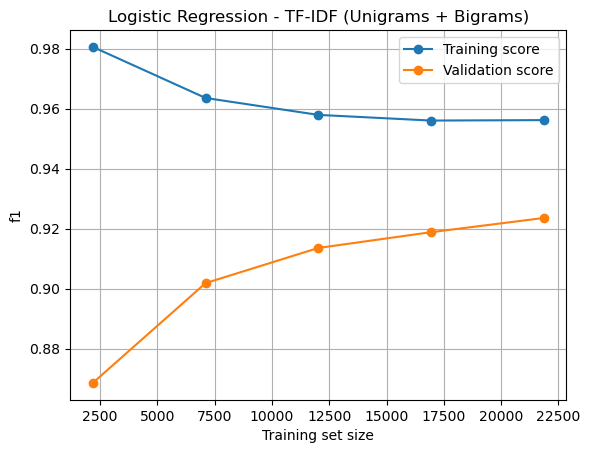

In [98]:
plot_learning_curve(
    model = log_reg,
    X = X_tfidf,
    y = y_train_lemm,
    scoring="f1",
    title="Logistic Regression - TF-IDF (Unigrams + Bigrams)"
)